In [1]:
pip install scikit-fuzzy


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install paho-mqtt

Note: you may need to restart the kernel to use updated packages.


c:\Users\ppg10\AppData\Local\Programs\Python\Python311\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


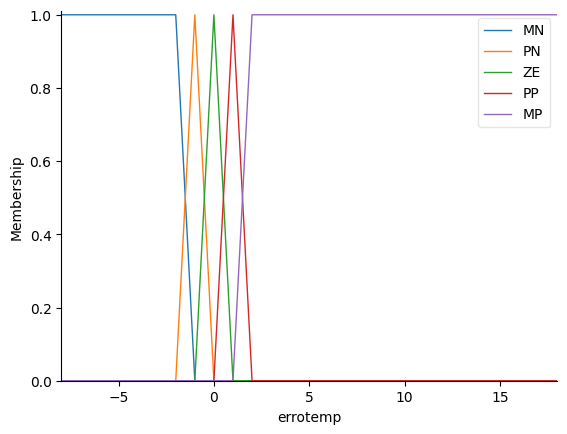

In [32]:
import numpy as np
import skfuzzy as fuzz
import paho.mqtt.client as mqtt
from skfuzzy import control as ctrl
import time

mqttBroker ="test.mosquitto.org"
client = mqtt.Client("c213Inatelsbm")
client.connect(mqttBroker)

errotemp = ctrl.Antecedent(np.arange(-8, 19, 1), 'errotemp')
varerrotemp = ctrl.Antecedent(np.arange(-2, 2.01, 0.01), 'varerrotemp')
resfriador = ctrl.Consequent(np.arange(0, 101, 1), 'resfriador')

# Definições de limites do erro
errotemp['MN'] = fuzz.trapmf(errotemp.universe, [-8, -8, -2, -1])
errotemp['PN'] = fuzz.trimf(errotemp.universe, [-2, -1, 0])
errotemp['ZE'] = fuzz.trimf(errotemp.universe, [-1, 0, 1])
errotemp['PP'] = fuzz.trimf(errotemp.universe, [0, 1, 2])
errotemp['MP'] = fuzz.trapmf(errotemp.universe,[1, 2, 18, 18])
errotemp.view()

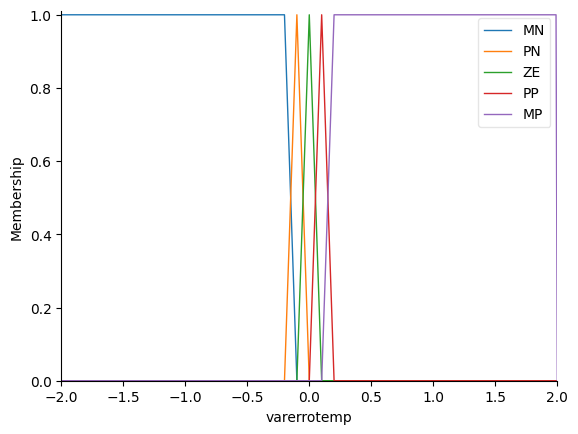

In [33]:
varerrotemp['MN'] = fuzz.trapmf(varerrotemp.universe, [-2, -2, -0.2,-0.1])
varerrotemp['PN'] = fuzz.trimf(varerrotemp.universe, [-0.2,-0.1,0])
varerrotemp['ZE'] = fuzz.trimf(varerrotemp.universe, [-0.1, 0, 0.1])
varerrotemp['PP'] = fuzz.trimf(varerrotemp.universe, [0, 0.1, 0.2])
varerrotemp['MP'] = fuzz.trapmf(varerrotemp.universe,[0.1, 0.2, 2,2])
varerrotemp.view()

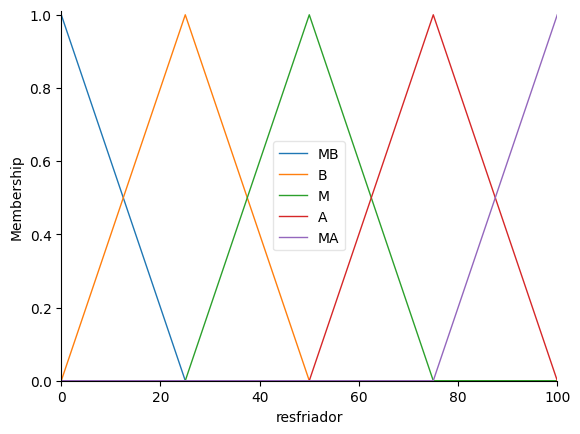

In [34]:
# Considerações
# Muito Baixo-> 0 a 25
# Baixo -> 25 a  50 
# Medio -> 25 a 75
# Alta -> 50 a 100
# Muito alta -> 75 a 100

resfriador['MB'] = fuzz.trimf(resfriador.universe, [0,0,25])
resfriador['B'] = fuzz.trimf(resfriador.universe, [0,25,50])
resfriador['M'] = fuzz.trimf(resfriador.universe, [25, 50, 75])
resfriador['A'] = fuzz.trimf(resfriador.universe, [50, 75, 100])
resfriador['MA'] = fuzz.trimf(resfriador.universe, [75, 100, 100])
resfriador.view()

In [35]:
# REGRAS RETIRADAS PELA TABELA
 
regra1 = ctrl.Rule(errotemp['MN']& varerrotemp['MN'], resfriador['MB'])
regra2 = ctrl.Rule(errotemp['PN']& varerrotemp['MN'], resfriador['MB'])
regra3 = ctrl.Rule(errotemp['ZE']& varerrotemp['MN'], resfriador['B'])
regra4 = ctrl.Rule(errotemp['PP']& varerrotemp['MN'], resfriador['M'])
regra5 = ctrl.Rule(errotemp['MP']& varerrotemp['MN'], resfriador['M'])

regra6 = ctrl.Rule(errotemp['MN']& varerrotemp['PN'], resfriador['MB'])
regra7 = ctrl.Rule(errotemp['PN']& varerrotemp['PN'], resfriador['B'])
regra8 = ctrl.Rule(errotemp['ZE']& varerrotemp['PN'], resfriador['B'])
regra9 = ctrl.Rule(errotemp['PP']& varerrotemp['PN'], resfriador['A'])
regra10 = ctrl.Rule(errotemp['MP']& varerrotemp['PN'], resfriador['A'])

regra11 = ctrl.Rule(errotemp['MN']& varerrotemp['ZE'], resfriador['MB'])
regra12 = ctrl.Rule(errotemp['PN']& varerrotemp['ZE'], resfriador['B'])
regra13 = ctrl.Rule(errotemp['ZE']& varerrotemp['ZE'], resfriador['M'])
regra14 = ctrl.Rule(errotemp['PP']& varerrotemp['ZE'], resfriador['A'])
regra15 = ctrl.Rule(errotemp['MP']& varerrotemp['ZE'], resfriador['MA'])

regra16 = ctrl.Rule(errotemp['MN']& varerrotemp['PP'], resfriador['B'])
regra17 = ctrl.Rule(errotemp['PN']& varerrotemp['PP'], resfriador['B'])
regra18 = ctrl.Rule(errotemp['ZE']& varerrotemp['PP'], resfriador['M'])
regra19 = ctrl.Rule(errotemp['PP']& varerrotemp['PP'], resfriador['A'])
regra20 = ctrl.Rule(errotemp['MP']& varerrotemp['PP'], resfriador['MA'])

regra21 = ctrl.Rule(errotemp['MN']& varerrotemp['MP'], resfriador['M'])
regra22 = ctrl.Rule(errotemp['PN']& varerrotemp['MP'], resfriador['M'])
regra23 = ctrl.Rule(errotemp['ZE']& varerrotemp['MP'], resfriador['A'])
regra24 = ctrl.Rule(errotemp['PP']& varerrotemp['MP'], resfriador['MA'])
regra25 = ctrl.Rule(errotemp['MP']& varerrotemp['MP'], resfriador['MA'])

In [36]:
resfriador_ctrl = ctrl.ControlSystem([regra1, regra2, regra3,regra4,regra5,regra6, regra7, regra8,regra9,regra10,regra11, regra12, regra13,regra14,regra15,regra16, regra17, regra18,regra19,regra20,regra21, regra22, regra23,regra24,regra25])
potencia = ctrl.ControlSystemSimulation(resfriador_ctrl)

In [38]:
sp= -6
tempatual=0
print(tempatual)
erroatual=6
while True: 
  erroanterior=erroatual
  erroatual=tempatual-sp
  varerroTemp=erroatual-erroanterior
  potencia.input['errotemp'] =erroatual
  potencia.input['varerrotemp'] =varerroTemp
  potencia.compute()
  i=0
  while (i < 10):
    tempatual= (tempatual * 0.9952) - (potencia.output['resfriador'] * 0.0003963)
    time.sleep(0.1)
    i += 1
  print(tempatual)
  client.publish("Resfriador/Temperatura", tempatual)
  client.publish("Resfriador/erro", erroatual)

0
-0.3555278594307312
-0.532750741606199
-0.7276889779025475
-0.8943475755420512
-1.081528543773516
-1.240708110434211
-1.417662235642867
-1.5712785740278647
-1.7370638754203498
-1.8853791408823524
-2.0405233075039386
-2.183074416994882


KeyboardInterrupt: 